# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


In [1]:
#required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import collections
import re
import pycountry
from os import path
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import bigrams
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import sentiment as senth


#local helper file import
import nlp_helper as nlph

# 1.Generate a word cloud based on emails' content

Load email with subjects, already extracted text and raw text.

In [2]:
raws = pd.read_csv('hillary-clinton-emails/Emails.csv',usecols=['ExtractedSubject','ExtractedBodyText','RawText'])
raws.head()

,ExtractedSubject,ExtractedBodyText,RawText
0,FW: Wow,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,Re: Chris Stevens,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,FVV: Cairo Condemnation - Final,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We see some NaN extractedSubject/extractedBodytext. After visualizing RawText, a majority of the cases can be explained (e.g no subject, email forwarding,..)
We decide to trust the latter and drop RawText

In [3]:
raws.drop(['RawText'], axis= 1,inplace=True)

In [4]:
body = pd.DataFrame()
body['text'] = raws.apply(nlph.concat_subj_txt, axis=1)
body.head()

,text
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris StevensThx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


Ok. dumb word cloud with concat of all cells.

In [5]:
text = ' '.join(body['text'])

In [6]:
text[:1000]

"FW: Wow B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary Re: Chris StevensThx FVV: Cairo Condemnation - Final H <hrod17@clintonemail.com>\nFriday, March 11, 2011 1:36 PM\nHuma Abedin\nFw: H: Latest: How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx\nPis print. Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly RiotsPis print.\n-•-...-^\nH < hrod17@clintonernailcom>\nWednesday, September 12, 2012 2:11 PM\n°Russorv@state.gov'\nFw: Meet The Right-Wing Extremist Behind Anti-fvluslim Film That Sparked Deadly Riots\nFrom [meat)\nSent: Wednesday, September 12, 2012 01:00 PM\nTo: 11\nSubject: Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly Riots\nhtte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked-\ndeadly-riots/\n

### 1.1. Naive Wordcloud on raw text

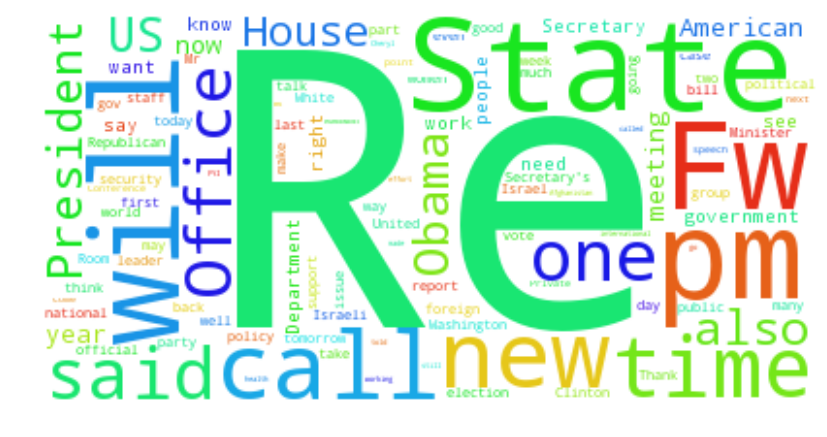

In [7]:
nlph.classic_cloud(text)

Not bad. Let's try something more stylish.

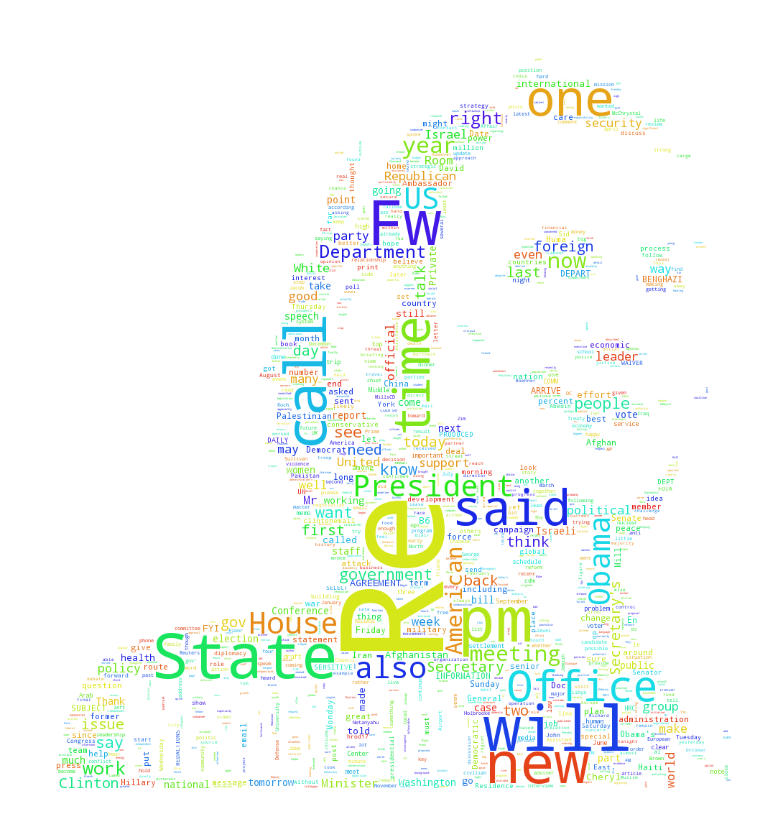

In [8]:
nlph.img_cloud(text, 'hc.png')

### 1.2. WordCloud on clean/preprocessed data
Observe frequent words and remove the ones that are frequent and unwanted

In [9]:
body_tokenized = [i for i in word_tokenize(text.lower())]

In [10]:
stop = set(stopwords.words('english'))
stop.update(string.punctuation) #Remove ponctuation

In [11]:
body_tokenized = [i for i in word_tokenize(text.lower()) if i not in stop]

After removing the 'english' stopwords and the punctuaction, we verify what we still need to remove

In [12]:
counter=collections.Counter(body_tokenized)
print(counter.most_common()[:50])

[("'s", 6008), ("''", 4209), ('``', 3675), ('pm', 2171), ('fw', 1850), ('state', 1675), ('would', 1585), ("n't", 1421), ('secretary', 1408), ('call', 1336), ('obama', 1246), ('said', 1242), ('--', 1226), ('new', 1192), ('office', 1175), ('president', 1136), ('one', 1112), ('time', 1017), ('u.s.', 994), ('also', 987), ('house', 977), ('h', 955), ('us', 939), ('—', 899), ('department', 883), ('2010', 830), ('2009', 823), ('people', 819), ('meeting', 804), ('get', 765), ('like', 754), ('clinton', 746), ('know', 724), ('•', 721), ('work', 713), ('government', 706), ('see', 705), ('today', 700), ('could', 697), ('foreign', 650), ('first', 648), ('last', 624), ('american', 615), ('two', 592), ('think', 591), ('back', 586), ('may', 583), ('security', 571), ('women', 569), ('state.gov', 568)]


We remove the unwanted words

In [13]:
stop.update(["'s", "''", "``", 'pm', 'fw', "n't", '--']) #Remove other unwanted characters and words

In [14]:
body_tokenized = [i for i in word_tokenize(text.lower()) if i not in stop]

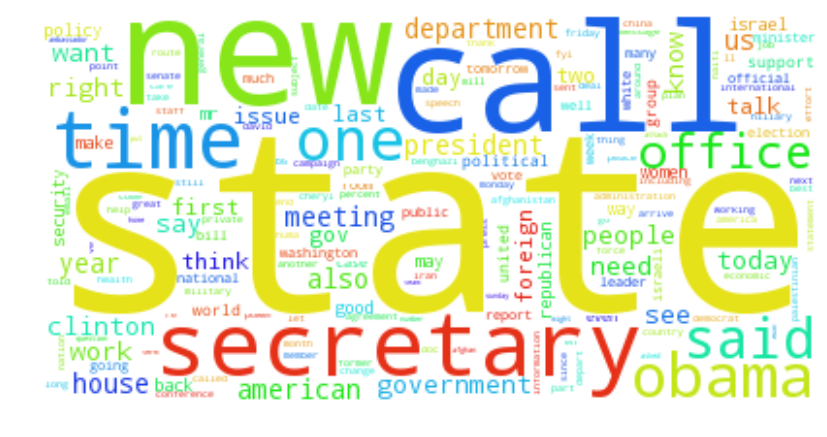

In [15]:
nlph.classic_cloud(' '.join(body_tokenized))

If we print body_tokenized, we can still see some unwanted strings like dots ('..', '...'), dates and url. Since they are quite rare, we could ignore their existence for the only purpose of drawing the workdcloud which only considers the most frequent tokens. However, we will need a clean data later on. We thus decide to remove the latters.

In [16]:
print(len(body_tokenized))
r = re.compile('[.]{1,3}$')
dots = set(filter(r.match, body_tokenized))
body_tokenized = [token for token in body_tokenized if token not in dots]
print(len(body_tokenized))

367762
367285


We thus removed 477 tokens. Now, let's remove the url and files.

In [17]:
is_file = lambda x: x.endswith('.docx')
is_url = lambda x: x.startswith('htte/') or x.startswith('http/')
body_tokenized = [token for token in body_tokenized if not is_file(token) and not is_url(token)]
print(len(body_tokenized))

367214


It is still not perfect since we still can find some unwanted symbols, useless dates/times and numbers.
Let's now try to apply some normalization techniques on our data.
Two classic methods are Stemming and Lemmatization.

In [18]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

stemmed = [porter.stem(token) for token in body_tokenized]
lemmatized = [wnl.lemmatize(token) for token in body_tokenized]

We now compute the word frequencies and look in their respective top10 for some potential differences.

In [19]:
count_stemm = collections.Counter(stemmed)
print("################## Stemmed Tokens ####################")
print(count_stemm.most_common()[:20])

count_lemm = collections.Counter(lemmatized)
print("################## Lemmatized Tokens #################")
print(count_lemm.most_common()[:20])

################## Stemmed Tokens ####################
[('state', 2271), ('call', 2013), ('would', 1585), ('secretari', 1460), ('time', 1371), ('offic', 1318), ('work', 1299), ('obama', 1249), ('presid', 1245), ('said', 1242), ('depart', 1224), ('new', 1192), ('one', 1163), ('meet', 1130), ('hous', 1015), ('u.s.', 994), ('like', 989), ('get', 987), ('also', 987), ('say', 958)]
################## Lemmatized Tokens #################
[('state', 2230), ('would', 1585), ('call', 1530), ('secretary', 1460), ('time', 1338), ('obama', 1246), ('said', 1242), ('office', 1203), ('new', 1192), ('u', 1190), ('president', 1179), ('one', 1163), ('u.s.', 994), ('also', 987), ('house', 985), ('h', 955), ('meeting', 915), ('american', 912), ('—', 899), ('department', 894)]


-----> Talk about differences <-------
We print the lemmatized wordcloud.

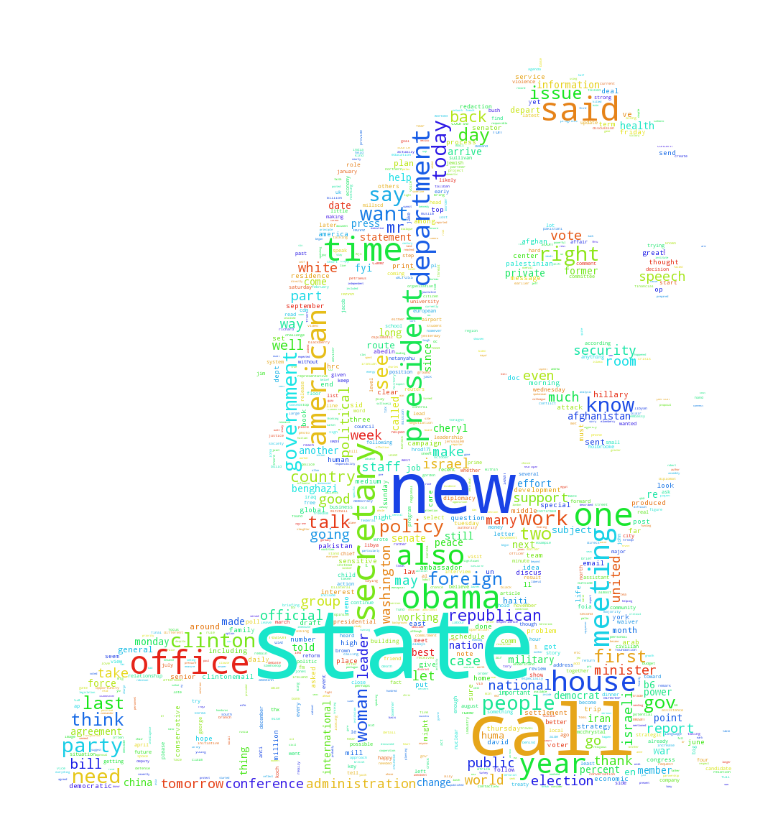

In [20]:
nlph.img_cloud(' '.join(lemmatized), 'hc.png')

Not much difference with not stemmed/lemmatized tokens.

---------> TODO: discuss pros/cons of each clouds<----------

### 1.3. Test: Frequency Analysis of bigrams

We see plenty of verbs and adjectives that lack some context to become meaningful. Let's start by creating bigrams from the "clean" text we obtained before. We could then check the top bigrams in term of frequency.

In [21]:
tokens_bigram = bigrams(lemmatized)
count_bigram= collections.Counter(tokens_bigram)
print(count_bigram.most_common()[:50])

[(('secretary', 'office'), 461), (('state', 'department'), 455), (('united', 'state'), 451), (('white', 'house'), 420), (('department', 'state'), 291), (('u.s.', 'department'), 261), (('secretary', 'state'), 260), (('new', 'york'), 230), (('state', 'dept'), 228), (('subject', 'agreement'), 216), (('benghazi', 'comm'), 216), (('sensitive', 'information'), 216), (('house', 'select'), 216), (('private', 'residence'), 216), (('information', 'redaction'), 216), (('agreement', 'sensitive'), 216), (('redaction', 'foia'), 216), (('produced', 'house'), 216), (('foia', 'waiver'), 216), (('select', 'benghazi'), 216), (('dept', 'produced'), 216), (('case', 'f-2015-04841'), 215), (('date', '05/13/2015'), 215), (('f-2015-04841', 'doc'), 215), (('state', 'case'), 212), (('comm', 'subject'), 212), (('05/13/2015', 'state'), 211), (('h', 'hrod17'), 206), (('mill', 'cheryl'), 202), (('hrod17', 'clintonemail.com'), 200), (('*en', 'route'), 193), (('prime', 'minister'), 179), (('health', 'care'), 171), (('

We observe some interesting pairs of words coming up. 

# 2. Identification of countries and sentiment analysis per email. Aggregation of perceptions on countries.

### 2.1. Detect Countries
We now want to extract the mentions of countries in the text of each email.
We will start with our DataFrame "body" which contained the aggregated text of the two fields (subject + body text). 

In [89]:
geo_body = body.copy()
geo_body.head()

,text
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris StevensThx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


We will try to extract the country names in each of our rows (=email). We thus create different helper lists from the pycountry set of countries. They will help us returning a country name from its alpha_2, alpha_3 and lower case form.

In [90]:
a2_name = {}
a3_name = {}
for c in pycountry.countries:
    a2_name[c.alpha_2] = c.name
    a3_name[c.alpha_3] = c.name
    
names = [c.name for c in pycountry.countries]
lowers = map(lambda s: s.lower(), names)
lower_to_name = {}
for c in pycountry.countries:
    lower_to_name[c.name.lower()] = c.name

We tokenize our rows and clean them a little bit by removing some punctuation tokens. We do not remove stop words since a country could be composed of multiple words including a stop word.
We also need to remove tokens like 'pm', 'fw' and others which could be detected as country ids (e.g pm <=> saint pierre and miquelon)

In [91]:
#tokenization
geo_body['text'] = geo_body.apply(lambda row: word_tokenize(row.text) , axis=1)
#punctuation removal
geo_body['text'] = geo_body.apply(lambda row: [i for i in row.text if i not in string.punctuation], axis=1)
#bad ids
geo_body['text'] = geo_body.apply(lambda row: [i for i in row.text if i not in ['PM', 'RE', 'AM', 'TO', 'FM', 'NO', 'AND']], axis=1)

geo_body.head()

,text
0,"[FW, Wow]"
1,"[B6, Thursday, March, 3, 2011, 9:45, H, Latest..."
2,"[Re, Chris, StevensThx]"
3,"[FVV, Cairo, Condemnation, Final]"
4,"[H, hrod17, clintonemail.com, Friday, March, 1..."


In [92]:
geo_body['countries'] = geo_body.apply(nlph.extract_country, axis=1)
geo_body.head(10)

,text,countries
0,"[FW, Wow]",[]
1,"[B6, Thursday, March, 3, 2011, 9:45, H, Latest...",[]
2,"[Re, Chris, StevensThx]",[]
3,"[FVV, Cairo, Condemnation, Final]",[]
4,"[H, hrod17, clintonemail.com, Friday, March, 1...",[]
5,"[Meet, The, Right, Wing, Extremist, Behind, An...",[]
6,"[FW, Anti-Muslim, film, director, in, hiding, ...","[Egypt, Libya]"
7,"[H, hrod17, clintonemail.corn, Friday, March, ...",[]
8,"[FVV, Secretary, 's, remarksFYI]",[]
9,"[more, on, LibyaB6, Wednesday, September, 12, ...",[Libya]


We have some first country results. However we need to go further since we are overlooking countries in two different scenarios:
- a country could be composed of multiple tokens (e.g united states)
- a country can be represented by a city (e.g Cairo, row 3)

We first create new columns containing the bigrams and 3-grams of each text and then search again for countries.

In [93]:
def composed_token(grams):
    return list(map(lambda x: ' '.join(x), grams))
        

geo_body['bigrams'] = geo_body.apply(lambda r: composed_token(bigrams(r.text)), axis=1)
geo_body['trigrams'] = geo_body.apply(lambda r: composed_token(ngrams(r.text,3)), axis=1)
geo_body.head()

,text,countries,bigrams,trigrams
0,"[FW, Wow]",[],[FW Wow],[]
1,"[B6, Thursday, March, 3, 2011, 9:45, H, Latest...",[],"[B6 Thursday, Thursday March, March 3, 3 2011,...","[B6 Thursday March, Thursday March 3, March 3 ..."
2,"[Re, Chris, StevensThx]",[],"[Re Chris, Chris StevensThx]",[Re Chris StevensThx]
3,"[FVV, Cairo, Condemnation, Final]",[],"[FVV Cairo, Cairo Condemnation, Condemnation F...","[FVV Cairo Condemnation, Cairo Condemnation Fi..."
4,"[H, hrod17, clintonemail.com, Friday, March, 1...",[],"[H hrod17, hrod17 clintonemail.com, clintonema...","[H hrod17 clintonemail.com, hrod17 clintonemai..."


updates countries and add the ones found through bigrams and trigrams.

In [94]:
geo_body['countries'] = geo_body.apply(nlph.bigram_search, axis=1)
geo_body['countries'] = geo_body.apply(nlph.trigram_search, axis=1)
geo_body.drop(['bigrams', 'trigrams'], axis=1, inplace=True)

In [95]:
geo_body.head(10)

,text,countries
0,"[FW, Wow]",[]
1,"[B6, Thursday, March, 3, 2011, 9:45, H, Latest...",[]
2,"[Re, Chris, StevensThx]",[]
3,"[FVV, Cairo, Condemnation, Final]",[]
4,"[H, hrod17, clintonemail.com, Friday, March, 1...",[]
5,"[Meet, The, Right, Wing, Extremist, Behind, An...",[]
6,"[FW, Anti-Muslim, film, director, in, hiding, ...","[Egypt, Libya]"
7,"[H, hrod17, clintonemail.corn, Friday, March, ...",[]
8,"[FVV, Secretary, 's, remarksFYI]",[]
9,"[more, on, LibyaB6, Wednesday, September, 12, ...",[Libya]


We obtained for instance the country United states and others.

We still lack the cases where cities are mentionned in an email without the country. 
We thus use a named-entity recognition classifier (stanford-nltk). We then query for the country of the locations obtained.

->__SEE NOTEBOOK: "__country_detection_stanfordNER.ipynb"

It is computationally expensive (~4-5h for a full location detection). 
TO RUN AND INSERT HERE.

### 2.2. Sentiment Analysis

As seen in the demos of the following page http://www.nltk.org/_modules/nltk/sentiment/util.html, there are many ways to compute a sentiment polarity or subjectivity of a given document.

The first solutions could be to train a classifier on an existing corpus and then classify our emails (see demo_twitter, demo_movies). However, those datasets are very domain specific. 

We thus decided to use two algorithms namely the Vader approach and the Liu Hu lexicon method.
Those two methods share the property that they do not need any training beforehand in order to classify a given sentence/text.


We first define the two row classification methods:


In [29]:
def vote(pos, neg):
    polarity = 0
    if pos > neg:
        polarity = 1
    elif pos < neg:
        polarity = -1
    return polarity

def vader_classify(row):
    vader_analyzer = SentimentIntensityAnalyzer()
    polarity = vader_analyzer.polarity_scores(row.text)
    pos = polarity['pos']
    neg = polarity['neg']
    return vote(pos, neg)

def liu_hu_classify(row):
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(row.text)]
    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1
        else:
            continue
    return vote(pos_words, neg_words)    

We now create a new dataframe including a column for each sentiment analysis method output per row email.

In [38]:
if 0:
    sent_body = body.copy()
    sent_body['Vader'] = sent_body.apply(vader_classify, axis=1)

Since the run is very computationally expensive we save the obtained dataframe.

|text|vader polarity|

In [39]:
if 0:
    sent_body.to_csv('sentiment_vader.csv', sep=',', encoding='utf-8')

Same for the Liu Hu method.
We do not run this sentiment analysis for now. it is very expensive and take too much time. We will try to run it later on and compare the obtained results with the vader outputs.
 
|text|vader polarity|liu hu polarity|

In [33]:
if 0:
    sent_body['LiuHu'] = sent_body.apply(liu_hu_classify, axis=1)
    sent_body.to_csv('sentiment_vader_liu_hu.csv', sep=',', encoding='utf-8')

We load our csv containing the table with vader sentiment analysis and concatenate it with the table containing the detected countries.

In [41]:
sent_body = pd.read_csv('sentiment_vader.csv', index_col=0)
sent_body.head()

,text,Vader
0,FW: Wow,1
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",0
2,Re: Chris StevensThx,0
3,FVV: Cairo Condemnation - Final,-1
4,"H <hrod17@clintonemail.com>\nFriday, March 11,...",0


In [96]:
geo_sent = pd.concat([geo_body, sent_body], axis=1)
geo_sent.drop(['text'], axis=1, inplace=True)
geo_sent.head(10)

,countries,Vader
0,[],1
1,[],0
2,[],0
3,[],-1
4,[],0
5,[],-1
6,"[Egypt, Libya]",-1
7,[],0
8,[],0
9,[Libya],0


We now desaggregate the countries.

In [ ]:
country_sentiment = pd.DataFrame(columns=['Country', 'Sentiment'])

def desaggregate(row):
    if len(row.countries) != 0:
        for c in row.countries:
            country_sentiment.loc[len(country_sentiment)] = [c, row.Vader]


geo_sent.apply(desaggregate, axis=1)
country_sentiment.head(10)

In [98]:
country_sentiment['Frequency'] = 1
country_sentiment = country_sentiment.groupby('Country').sum()
country_sentiment['Sentiment'] = country_sentiment['Sentiment'] / country_sentiment['Frequency']

In [100]:
country_sentiment = country_sentiment.sort_values(by='Frequency', ascending=False)
country_sentiment.head(10)

,Sentiment,Frequency
Country,,
United States,0.418539,356
India,0.431818,220
Haiti,0.414815,135
Afghanistan,0.371901,121
Israel,0.279661,118
Pakistan,0.230000,100
China,0.414141,99
Libya,-0.089744,78
Iraq,0.250000,76


We now plot the country frequencies as well as a sentiment indicator.

### 2.3. Desaggregate country arrays

Take emails mentionning countries (column countries not empty array).

Duplicate email row for each country // Remove text column

Plot Histogram: country/frequency/sentiment